## Car Popularity Prediction - GS Codesprint 2018

**Introduction**
A car company has the data for all the cars that are present in the market. They are planning to introduce some new ones of their own, but first, they want to find out what would be the popularity of the new cars in the market based on each car's attributes.

We will provide you a dataset of cars along with the attributes of each car along with its popularity. Your task is to train a model that can predict the popularity of new cars based on the given attributes.

**Dataset**
You are given a training dataset, train.csv. The file is a comma separated file with useful information for this task:

train.csv contains the information about a car along with its popularity level. Each row provides information on each car. Information such as buying_price, maintenance_cost, number_of_doors, number_of_seats, etc. The definition of each attribute is as follows:

- *buying_price:* The buying_price denotes the buying price of the car, and it ranges from [1...4], where buying_price equal to 1 represents the lowest price while buying_price equal to 4 represents the highest price.
- *maintenance_cost:* The maintenance_cost denotes the maintenance cost of the car, and it ranges from [1...4], where maintenance_cost equal to 1 represents the lowest cost while maintenance_cost equal to 4 represents the highest cost.
- *number_of_doors:* The number_of_doors denotes the number of doors in the car, and it ranges from [2...5], where each value of number_of_doors represents the number of doors in the car.
- *number_of_seats:* The number_of_seats denotes the number of seats in the car, and it consists of [2, 4, 5], where each value of number_of_seats represents the number of seats in the car.
- *luggage_boot_size:* The luggage_boot_size denotes the luggage boot size, and it ranges from [1...3], where luggage_boot_size equal to 1 represents smallest luggage boot size while luggage_boot_size equal to 3 represents largest luggage boot size.
- *safety_rating:* The safety_rating denotes the safety rating of the car, and it ranges from [1...3], where safety_rating equal to 1 represents low safety while safety_rating equal to 3 represents high safety.
- *popularity:* The popularity denotes the popularity of the car, and it ranges from [1...4], where popularity equal to 1 represents an unacceptable car, popularity equal to 2 represents an acceptable car, popularity equal to 3 represents a good car, and popularity equal to 4 represents the best car.

We also provide a test set of  car along with the above attributes excluding popularity, in test.csv. The goal is to predict the popularity of the car based on its attributes.

[Link to competition](https://www.hackerrank.com/contests/gs-codesprint-2018/challenges/car-popularity-prediction)

In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Modelling Helpers
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualisations
%matplotlib inline
sns.set_style( 'white' )

In [2]:
train = pd.read_csv('data/train.csv')
# test set doesn't have header
test  = pd.read_csv('data/test.csv', header= None, names=['buying_price','maintainence_cost','number_of_doors','number_of_seats','luggage_boot_size','safety_rating'])

In [3]:
train.head()

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,popularity
0,3,2,4,2,2,2,1
1,3,2,2,5,2,1,1
2,1,4,2,5,1,3,1
3,4,4,2,2,1,2,1
4,3,3,3,4,3,3,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 7 columns):
buying_price         1628 non-null int64
maintainence_cost    1628 non-null int64
number_of_doors      1628 non-null int64
number_of_seats      1628 non-null int64
luggage_boot_size    1628 non-null int64
safety_rating        1628 non-null int64
popularity           1628 non-null int64
dtypes: int64(7)
memory usage: 89.1 KB


In [5]:
test.head()

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating
0,4,1,2,2,2,2
1,2,1,3,4,3,2
2,4,4,2,5,1,2
3,4,3,3,2,2,2
4,4,2,2,4,3,2


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
buying_price         100 non-null int64
maintainence_cost    100 non-null int64
number_of_doors      100 non-null int64
number_of_seats      100 non-null int64
luggage_boot_size    100 non-null int64
safety_rating        100 non-null int64
dtypes: int64(6)
memory usage: 4.8 KB


Both train an test sets have no missing values, and all values are ordinal and nominal

In [7]:
# Checking any anomalities
for item in train.columns:
    print('unique values of {} are {}'.format(item, train[item].unique()))

unique values of buying_price are [3 1 4 2]
unique values of maintainence_cost are [2 4 3 1]
unique values of number_of_doors are [4 2 3 5]
unique values of number_of_seats are [2 5 4]
unique values of luggage_boot_size are [2 1 3]
unique values of safety_rating are [2 1 3]
unique values of popularity are [1 2 3 4]


In [8]:
# Checking any anomalities
for item in test.columns:
    print('unique values of {} are {}'.format(item, train[item].unique()))

unique values of buying_price are [3 1 4 2]
unique values of maintainence_cost are [2 4 3 1]
unique values of number_of_doors are [4 2 3 5]
unique values of number_of_seats are [2 5 4]
unique values of luggage_boot_size are [2 1 3]
unique values of safety_rating are [2 1 3]


buying_price, maintainence_cost, luggage_boot_size, safety_rating are ranked from low to high, they need transformations
number_of_doors, number_of_seats are categorical variables and they can be transformed using dummies

In [9]:
def count_var(data,col):
    dic_test = {}
    ix = list(data.columns).index(col)+1
    for row in data.itertuples():
        if row[ix] in dic_test:
            dic_test[row[ix]] = dic_test[row[ix]] + 1
        else:
            dic_test[row[ix]] = 1
    return dic_test

In [10]:
# normalize features that are ordinal
def transform_values(data,col_lis):
    for col in col_lis:
        dic = count_var(data,col)
        data['norm'+'_'+col] = data[col].apply(lambda x: x/data[col].max())
        data['sr'+'_'+col]   = data[col].apply(lambda x: dic[x]/data.shape[0])

In [11]:
transform_values(train,['buying_price','maintainence_cost','luggage_boot_size','safety_rating'])
transform_values(test,['buying_price','maintainence_cost','luggage_boot_size','safety_rating'])

In [12]:
train.head()

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,popularity,norm_buying_price,sr_buying_price,norm_maintainence_cost,sr_maintainence_cost,norm_luggage_boot_size,sr_luggage_boot_size,norm_safety_rating,sr_safety_rating
0,3,2,4,2,2,2,1,0.75,0.258600,0.50,0.248157,0.666667,0.333538,0.666667,0.328010
1,3,2,2,5,2,1,1,0.75,0.258600,0.50,0.248157,0.666667,0.333538,0.333333,0.347052
2,1,4,2,5,1,3,1,0.25,0.235872,1.00,0.257985,0.333333,0.339681,1.000000,0.324939
3,4,4,2,2,1,2,1,1.00,0.254914,1.00,0.257985,0.333333,0.339681,0.666667,0.328010
4,3,3,3,4,3,3,2,0.75,0.258600,0.75,0.253071,1.000000,0.326781,1.000000,0.324939


In [13]:
test.head()

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,norm_buying_price,sr_buying_price,norm_maintainence_cost,sr_maintainence_cost,norm_luggage_boot_size,sr_luggage_boot_size,norm_safety_rating,sr_safety_rating
0,4,1,2,2,2,2,1.0,0.17,0.25,0.40,0.666667,0.33,0.666667,0.42
1,2,1,3,4,3,2,0.5,0.24,0.25,0.40,1.000000,0.44,0.666667,0.42
2,4,4,2,5,1,2,1.0,0.17,1.00,0.12,0.333333,0.23,0.666667,0.42
3,4,3,3,2,2,2,1.0,0.17,0.75,0.20,0.666667,0.33,0.666667,0.42
4,4,2,2,4,3,2,1.0,0.17,0.50,0.28,1.000000,0.44,0.666667,0.42


In [14]:
train.drop(['buying_price','maintainence_cost','luggage_boot_size','safety_rating'], axis=1,inplace=True)
test.drop(['buying_price','maintainence_cost','luggage_boot_size','safety_rating'], axis=1,inplace=True)

In [15]:
train.head()

,number_of_doors,number_of_seats,popularity,norm_buying_price,sr_buying_price,norm_maintainence_cost,sr_maintainence_cost,norm_luggage_boot_size,sr_luggage_boot_size,norm_safety_rating,sr_safety_rating
0,4,2,1,0.75,0.258600,0.50,0.248157,0.666667,0.333538,0.666667,0.328010
1,2,5,1,0.75,0.258600,0.50,0.248157,0.666667,0.333538,0.333333,0.347052
2,2,5,1,0.25,0.235872,1.00,0.257985,0.333333,0.339681,1.000000,0.324939
3,2,2,1,1.00,0.254914,1.00,0.257985,0.333333,0.339681,0.666667,0.328010
4,3,4,2,0.75,0.258600,0.75,0.253071,1.000000,0.326781,1.000000,0.324939


In [16]:
def transform_dummy(data, col_list):
    for col in col_list:
        dumy = pd.get_dummies(data[col],prefix=col)
        data = pd.concat([data,dumy],axis=1)
        data.drop(col,axis=1,inplace=True)
    return data

In [17]:
train = transform_dummy(train,['number_of_doors','number_of_seats'])
test = transform_dummy(test,['number_of_doors','number_of_seats'])

In [18]:
train.head()

,popularity,norm_buying_price,sr_buying_price,norm_maintainence_cost,sr_maintainence_cost,norm_luggage_boot_size,sr_luggage_boot_size,norm_safety_rating,sr_safety_rating,number_of_doors_2,number_of_doors_3,number_of_doors_4,number_of_doors_5,number_of_seats_2,number_of_seats_4,number_of_seats_5
0,1,0.75,0.258600,0.50,0.248157,0.666667,0.333538,0.666667,0.328010,0,0,1,0,1,0,0
1,1,0.75,0.258600,0.50,0.248157,0.666667,0.333538,0.333333,0.347052,1,0,0,0,0,0,1
2,1,0.25,0.235872,1.00,0.257985,0.333333,0.339681,1.000000,0.324939,1,0,0,0,0,0,1
3,1,1.00,0.254914,1.00,0.257985,0.333333,0.339681,0.666667,0.328010,1,0,0,0,1,0,0
4,2,0.75,0.258600,0.75,0.253071,1.000000,0.326781,1.000000,0.324939,0,1,0,0,0,1,0


In [19]:
test.head()

,norm_buying_price,sr_buying_price,norm_maintainence_cost,sr_maintainence_cost,norm_luggage_boot_size,sr_luggage_boot_size,norm_safety_rating,sr_safety_rating,number_of_doors_2,number_of_doors_3,number_of_doors_4,number_of_doors_5,number_of_seats_2,number_of_seats_4,number_of_seats_5
0,1.0,0.17,0.25,0.40,0.666667,0.33,0.666667,0.42,1,0,0,0,1,0,0
1,0.5,0.24,0.25,0.40,1.000000,0.44,0.666667,0.42,0,1,0,0,0,1,0
2,1.0,0.17,1.00,0.12,0.333333,0.23,0.666667,0.42,1,0,0,0,0,0,1
3,1.0,0.17,0.75,0.20,0.666667,0.33,0.666667,0.42,0,1,0,0,1,0,0
4,1.0,0.17,0.50,0.28,1.000000,0.44,0.666667,0.42,1,0,0,0,0,1,0


In [20]:
raw_data = pd.read_csv('data/train.csv')

In [21]:
raw_data['popularity'].value_counts()

1    1185
2     359
3      44
4      40
Name: popularity, dtype: int64

In [22]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

f:\Users\Tahar\Anacondanew\envs\ztdl\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


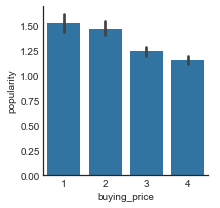

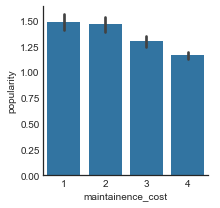

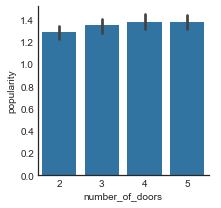

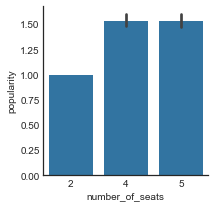

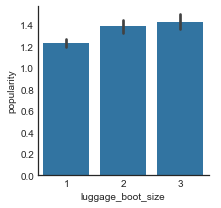

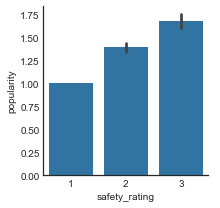

In [23]:
for i in ['buying_price','maintainence_cost','number_of_doors','number_of_seats','luggage_boot_size','safety_rating']:
    plot_categories(raw_data , cat = i , target = 'popularity' )

## Model

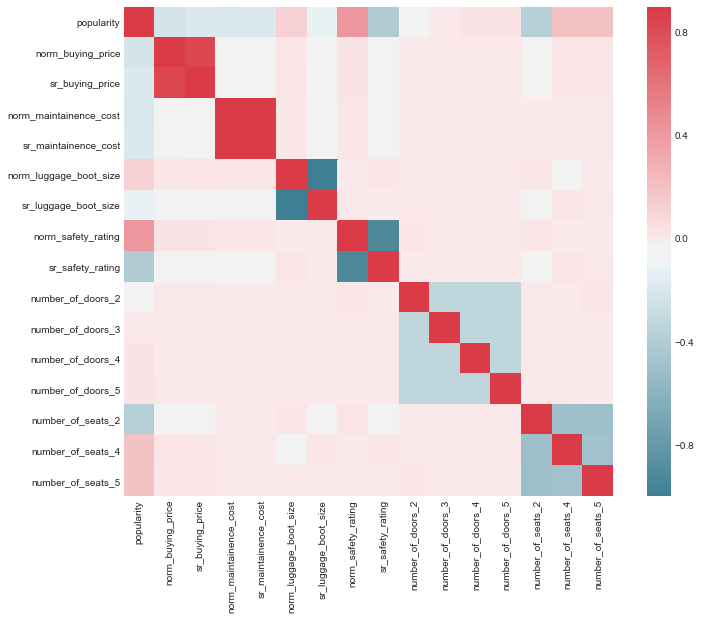

In [24]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap=sns.diverging_palette( 220 , 10 , as_cmap = True ))

In [25]:
train.shape

(1628, 16)

In [26]:
msk = np.random.rand(len(train)) < 0.8

In [27]:
# split train data between Train and Test sets
train_set = train[msk]
test_set = train[~msk]

In [28]:
train_set.shape, test_set.shape

((1294, 16), (334, 16))

In [29]:
# exclude normalized features and add them in the meta classifier later
X = train_set.drop(['popularity','norm_maintainence_cost','norm_luggage_boot_size','norm_safety_rating','norm_buying_price'],axis=1).values
y = train_set['popularity'].values
test_sub = test.values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
X_train.shape, X_test.shape

((1035, 11), (259, 11))

In [32]:
# there is class unbalance, use StratifiedKfold to keep correct proportions
kfold = StratifiedKFold(n_splits=3, shuffle=True)

In [33]:
# create a custom score based on competition specifications

from sklearn.metrics.scorer import make_scorer
def s_score(y,y_pred):
    f1_score = []
    s_nominator = []
    s_denominator = []
    for i in range(1,5):
        y_tp = y_pred[(y_pred==i)&(y==i)]
        y_tn = y_pred[(y_pred!=i)&(y!=i)]
        y_fp  = y_pred[(y_pred==i)&(y!=i)]
        y_fn  = y_pred[(y_pred!=i)&(y==i)]
        try:
            pr =  len(y_tp)/(len(y_tp)+len(y_fp))
            re =  len(y_tp)/(len(y_tp)+len(y_fn))
            f1 = 2*pr*re/(pr+re)
        except:
            pr = 0
            re = 0
            f1 = 0
        finally:
            f1_score.append(f1)
            s_nominator.append(f1*len(y_tp))
            s_denominator.append(len(y_tp))
    return sum(s_nominator)/sum(s_denominator)*1000



my_score = make_scorer(s_score)

In [34]:
random_state = 22
classifiers = [] # combine all alogorithms in a list
classifiers.append(SVC(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))


Text(0.5,1,'Cross validation scores before hypertunning')

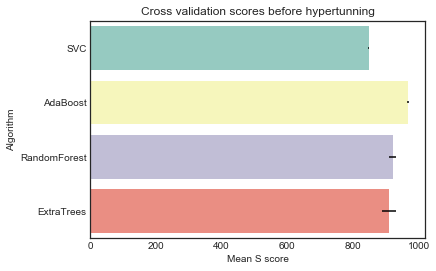

In [35]:
cv_results = [] 
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring=my_score, cv=kfold, n_jobs=1))

cv_means = []
cv_std   = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors':cv_std,
                      "Algorithm":['SVC','AdaBoost','RandomForest','ExtraTrees']})
# Make a bar graph of cross validation results
f = sns.barplot('CrossValMeans','Algorithm',data=cv_df,palette='Set3',orient='h', **{'xerr':cv_std})
f.set_xlabel("Mean S score")
f.set_title('Cross validation scores before hypertunning')
    
    



In [36]:
# This is a function to calculate confidence interval, check Sebastian Raschka blog for reference https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html
n = len(y_test)
z = 1.96
def conf_inter(ACC,n,z):
    print ("the condifedence interval is ({},{})".format(ACC-z*((1/n)*ACC*(1-ACC))**0.5,ACC+z*((1/n)*ACC*(1-ACC))**0.5))

In [37]:
s_scores = []

In [38]:
# Hyper parameters tunning

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring=my_score, n_jobs= 1, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best1 = gsadaDTC.best_estimator_

s_scores.append(s_score(y_test,ada_best1.predict(X_test)))
print('Cross validation score: {}\nTest score: {}'.format(gsadaDTC.best_score_,s_score(y_test,ada_best1.predict(X_test))))

Fitting 3 folds for each of 112 candidates, totalling 336 fits
Cross validation score: 959.8676395095155
Test score: 952.0482324467541


[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:    2.3s finished


In [39]:
ACC = s_score(y_test,ada_best1.predict(X_test))/1000

conf_inter(ACC,n,z)

the condifedence interval is (0.9260263940748804,0.9780700708186277)


In [40]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring=my_score, n_jobs= 1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best1 = gsExtC.best_estimator_

s_scores.append(s_score(y_test,ExtC_best1.predict(X_test)))
# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsExtC.best_score_,s_score(y_test,ExtC_best1.predict(X_test))))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   12.0s finished


Cross validation score: 925.1023959806587
Test score: 949.6672191080119


In [41]:
ACC = s_score(y_test,ExtC_best1.predict(X_test))/1000
conf_inter(ACC,n,z)

the condifedence interval is (0.9230405172274492,0.9762939209885746)


In [42]:

# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {'max_depth' : [5,6,7,8],
              "max_features": [3, 5, 'sqrt'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[300],
              "criterion": ["gini",'entropy']}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring=my_score, n_jobs= 1, verbose = 1,)

gsRFC.fit(X_train,y_train)

RFC_best1 = gsRFC.best_estimator_

s_scores.append(s_score(y_test,RFC_best1.predict(X_test)))

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsRFC.best_score_,s_score(y_test,RFC_best1.predict(X_test))))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  9.5min finished


Cross validation score: 960.9225922178775
Test score: 974.4232991359427


In [43]:
ACC = s_score(y_test,RFC_best1.predict(X_test))/1000
conf_inter(ACC,n,z)

the condifedence interval is (0.9551967084271775,0.9936498898447079)


In [44]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf','linear'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 1, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best1 = gsSVMC.best_estimator_

s_scores.append(s_score(y_test,SVMC_best1.predict(X_test)))
# Best score
gsSVMC.best_score_
print('Cross validation score: {}\nTest score: {}'.format(gsSVMC.best_score_,s_score(y_test,SVMC_best1.predict(X_test))))

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:  1.3min finished


Cross validation score: 0.8724637681159421
Test score: 912.5234563488516


In [45]:
ACC = s_score(y_test,SVMC_best1.predict(X_test))/1000
conf_inter(ACC,n,z)

the condifedence interval is (0.878114300747022,0.9469326119506811)


Text(0.5,1,'Cross validation scores after hypertunning')

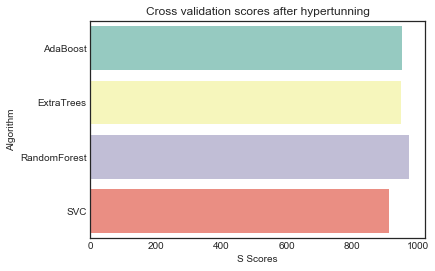

In [46]:
test_df = pd.DataFrame({'CrossValMeans':s_scores,
                      "Algorithm":['AdaBoost','ExtraTrees','RandomForest','SVC']})
# Make a bar graph of cross validation results
f = sns.barplot('CrossValMeans','Algorithm',data=test_df,palette='Set3',orient='h')
f.set_xlabel("S Scores")
f.set_title('Cross validation scores after hypertunning')

In [47]:
# use normalized features for the meta classifier
norm_features = train_set[['norm_maintainence_cost','norm_luggage_boot_size','norm_safety_rating','norm_buying_price']].values

In [48]:
train_norm = norm_features

In [49]:
# add predictions of previous classifiers to new train set
for i in [ada_best1.predict(X).T,ExtC_best1.predict(X).T,RFC_best1.predict(X).T,SVMC_best1.predict(X).T]:
    train_norm = np.column_stack((train_norm,i ))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(train_norm, y, test_size=0.2, random_state=41, stratify=y)

In [51]:
s_scores = []

Text(0.5,1,'Cross validation scores before hypertunning')

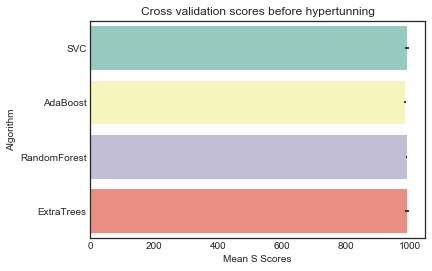

In [52]:
cv_results = [] 
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring=my_score, cv=kfold, n_jobs=1))

cv_means = []
cv_std   = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors':cv_std,
                      "Algorithm":['SVC','AdaBoost','RandomForest','ExtraTrees']})
# Make a bar graph of cross validation results
f = sns.barplot('CrossValMeans','Algorithm',data=cv_df,palette='Set3',orient='h', **{'xerr':cv_std})
f.set_xlabel("Mean S Scores")
f.set_title('Cross validation scores before hypertunning')
    

In [53]:
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring=my_score, n_jobs= 1, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best2 = gsadaDTC.best_estimator_

s_scores.append(s_score(y_test,ada_best2.predict(X_test)))
print('Cross validation score: {}\nTest score: {}'.format(gsadaDTC.best_score_,s_score(y_test,ada_best2.predict(X_test))))

Fitting 3 folds for each of 112 candidates, totalling 336 fits
Cross validation score: 986.2117648461895
Test score: 984.0335517500872


[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:    3.3s finished


In [54]:
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring=my_score, n_jobs= 1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best2 = gsExtC.best_estimator_

s_scores.append(s_score(y_test,ExtC_best2.predict(X_test)))
# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsExtC.best_score_,s_score(y_test,ExtC_best2.predict(X_test))))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   12.2s finished


Cross validation score: 990.6021841886197
Test score: 996.4221824686941


In [55]:
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring=my_score, n_jobs= 1, verbose = 1,)

gsRFC.fit(X_train,y_train)

RFC_best2 = gsRFC.best_estimator_

s_scores.append(s_score(y_test,RFC_best2.predict(X_test)))

# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsRFC.best_score_,s_score(y_test,RFC_best2.predict(X_test))))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 10.3min finished


Cross validation score: 990.6002570278653
Test score: 992.5395607661396


In [56]:
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 1, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best2 = gsSVMC.best_estimator_

s_scores.append(s_score(y_test,SVMC_best2.predict(X_test)))
# Best score
gsSVMC.best_score_
print('Cross validation score: {}\nTest score: {}'.format(gsSVMC.best_score_,s_score(y_test,SVMC_best2.predict(X_test))))

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Cross validation score: 0.9884057971014493
Test score: 996.1462947285844


[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    6.2s finished


Text(0.5,1,'Cross validation scores after hypertuning ')

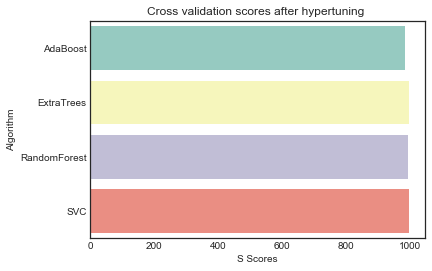

In [57]:
test_df = pd.DataFrame({'CrossValMeans':s_scores,
                      "Algorithm":['AdaBoost','ExtraTrees','RandomForest','SVC']})
# Make a bar graph of cross validation results
f = sns.barplot('CrossValMeans','Algorithm',data=test_df,palette='Set3',orient='h')
f.set_xlabel("S Scores")
f.set_title('Cross validation scores after hypertuning ')

In [58]:
# use VotingClassifier for first list of classifiers
vc1 = VotingClassifier([('ada1',ada_best1),('extree1',ExtC_best1),('rf1',RFC_best1),('svc1',SVMC_best1)],weights=[3,2,4,1],voting='soft')
vc1.fit(X_train,y_train)

VotingClassifier(estimators=[('ada1', AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[3, 2, 4, 1])

In [59]:
# use VotingClassifier for second list of classifiers
vc2 = VotingClassifier([('ada1',ada_best2),('extree1',ExtC_best2),('rf1',RFC_best2),('svc1',SVMC_best2)],weights=[3,2,4,1],voting='soft')
vc2.fit(X_train,y_train)

VotingClassifier(estimators=[('ada1', AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[3, 2, 4, 1])

In [60]:
# create meta dataset for final predictions
X_meta = np.ones(train_set['popularity'].values.shape[0])
for clf in [vc1,vc2]:
    clf.fit(train_set.drop('popularity',axis=1).values,train_set['popularity'].values)
    y_pred = clf.predict(train_set.drop('popularity',axis=1).values)
    X_meta = np.vstack((X_meta,y_pred))
X_meta = X_meta[1:].T

In [61]:
X_meta.shape, train_set.shape

((1294, 2), (1294, 16))

In [62]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, train_set['popularity'].values, test_size=0.2, stratify=train_set['popularity'].values)

In [63]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {'max_depth' : [5,6,7,8],
              "max_features": [1, 2, 'sqrt'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[300],
              "criterion": ["gini",'entropy']}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring=my_score, n_jobs= 1, verbose = 1,)

gsRFC.fit(X_train_meta,y_train_meta)

RFC_meta = gsRFC.best_estimator_


# Best score
print('Cross validation score: {}\nTest score: {}'.format(gsRFC.best_score_,s_score(y_test_meta,RFC_meta.predict(X_test_meta))))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  9.8min finished


Cross validation score: 996.1808406532214
Test score: 992.3078610924198


In [64]:
# Make meta prediction on the test set
X_meta_test = np.ones(test_set['popularity'].values.shape[0])
for clf in [vc1,vc2]:
    y_pred_test = clf.predict(test_set.drop('popularity',axis=1).values)
    X_meta_test = np.vstack((X_meta_test,y_pred_test))
X_meta_test = X_meta_test[1:].T

In [65]:
y_pred_test = RFC_meta.predict(X_meta_test)
s_score(test_set['popularity'].values,RFC_meta.predict(X_meta_test))

970.1348707047096

In [66]:
# make prediction on the final submission set
X_meta_sub = np.ones(test.values.shape[0])
for clf in [vc1,vc2]:
    y_pred_sub = clf.predict(test.values)
    X_meta_sub = np.vstack((X_meta_sub,y_pred_sub))
X_meta_sub = X_meta_sub[1:].T
Y_test_sub = RFC_meta.predict(X_meta_sub)

In [67]:
test_sub = pd.DataFrame(Y_test_sub)
test_sub.to_csv( 'prediction.csv' , float_format='%.f', index = False, header=False)